### Responsible Data Science Course Project: Nutritional Labels for Automated Decision Systems

Rohan Mahadev - rm5310, Anindya Chakravarti - ac8184

In [1]:
import os
import yaml
import pickle
import argparse

import numpy as np
import torch
torch.backends.cudnn.benchmark=True
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from PIL import Image

from datasets import LabeledImages
from models.se_resnet import se_resnet101
# Helper functions to draw predictions:

import torchvision.transforms as T

import pandas as pd

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
CONFIG_PATH = './config.yaml'

# ADS being evaluated

In [3]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.n_classes = n_classes
        self.features = se_resnet101()
        self.classifier = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class ModelWithLoss(nn.Module):
    def __init__(self, classifier):
        super(ModelWithLoss, self).__init__()
        self.classifier = classifier
        self.criterion = nn.CrossEntropyLoss(size_average=False)

    def forward(self, x, labels):
        assert len(x) == len(labels)

        predictions = self.classifier(x)

        all_classes = np.arange(self.classifier.n_classes, dtype=np.int64)
        zero_label = torch.tensor([0]).to(x.device)

        loss = 0
        denominator = 0
        for prediction, positives in zip(predictions, labels):
            negatives = np.setdiff1d(all_classes, positives, assume_unique=True)
            negatives_tensor = torch.tensor(negatives).to(x.device)
            positives_tensor = torch.tensor(positives).to(x.device).unsqueeze(dim=1)

            for positive in positives_tensor:
                indices = torch.cat((positive, negatives_tensor))
                loss = loss + self.criterion(prediction[indices].unsqueeze(dim=0), zero_label)
                denominator += 1

        loss /= denominator

        return loss

    def predict(self, x, top_k):
        input_shape = x.shape
        if len(input_shape) == 5:
            x = x.view(-1, input_shape[2], input_shape[3], input_shape[4])
            predictions = self.classifier(x)
            predictions = predictions.view(input_shape[0], input_shape[1], -1).mean(dim=1)
        else:
            predictions = self.classifier(x)

        scores, labels = predictions.sort(dim=1, descending=True)

        pred_scores = np.zeros(shape=(len(scores), top_k), dtype=np.float32)
        pred_labels = labels[:, :top_k].cpu().numpy()

        for i in range(top_k):
            i_scores = torch.cat((scores[:, i:i + 1], scores[:, top_k:]), dim=1)
            pred_scores[:, i] = F.softmax(i_scores, dim=1)[:, 0].cpu().numpy()

        return pred_scores, pred_labels

In [4]:
with open(CONFIG_PATH, 'r') as f:
    config = yaml.load(f)

In [5]:
dataset_root = config['DATASET']['STAGE2_TEST_IMAGES_ROOT']

In [6]:
assert os.path.exists(dataset_root), dataset_root
sample_submission_path = config['DATASET']['STAGE{}_SAMPLE_SUBMISSION_PATH'.format(2)]
assert os.path.exists(sample_submission_path), sample_submission_path

output_root = config['SUBMISSION']['OUTPUT_ROOT']
assert os.path.exists(output_root), output_root

test_list_path = os.path.join(output_root, 'test_stage{}.txt'.format(2))

In [7]:
with open(config['DATASET']['NAME_TO_LABEL_PATH'], 'rb') as f:
    name_to_label = pickle.load(f)
label_to_name = {label: name for name, label in name_to_label.items()}
n_classes = len(name_to_label)

In [8]:
classifier = Classifier(n_classes)
model = ModelWithLoss(classifier).cuda().eval()

/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [9]:
snapshot_path = os.path.join(config['TUNING']['ARTIFACTS_ROOT'], 'snapshots',
                                 'snapshot_epoch_{}.pth.tar'.format(config['TUNING']['N_EPOCH']))
state = torch.load(snapshot_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state['model'])

<All keys matched successfully>

In [10]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = T.Compose([T.ToTensor(), normalize])

In [11]:
description = pd.read_csv('../../class-descriptions2.csv')
label_lookup = {label: descr for label, descr in zip(description.label_code.values, description.description.values)}

In [12]:
def run_pred(path):
    threshold = config['SUBMISSION']['THRESHOLD']
    min_preds = config['SUBMISSION']['MIN_PREDS']
    max_preds = config['SUBMISSION']['MAX_PREDS']
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,50)
    fontScale              = 0.6
    fontColor              = (255,255,255)
    lineType               = 2
    
    img = Image.open(path)
    transform = T.Compose([T.Resize(256),T.TenCrop(224),
                           T.Lambda(lambda crops: torch.stack([to_tensor(crop) for crop in crops]))])
    img1 = transform(img)
    img1 = img1.unsqueeze(0)
    
    cv_img = cv2.imread(path)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    with torch.no_grad():
        pred_scores, pred_labels = model.predict(img1.to(device), config['SUBMISSION']['TOP_K'])
        pred_names = [label_lookup[label_to_name[label]] for label in pred_labels[0]]
        print(pred_names)
        print(pred_scores)
        cv2.putText(cv_img,", ".join(pred_names[:4]), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)
        plt.figure(figsize=(50,50))
        plt.imshow(cv_img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

['Person', 'Human face', 'Man', 'Human nose', 'Human hair']
[[0.996847   0.8727455  0.76645243 0.13708109 0.1338204 ]]


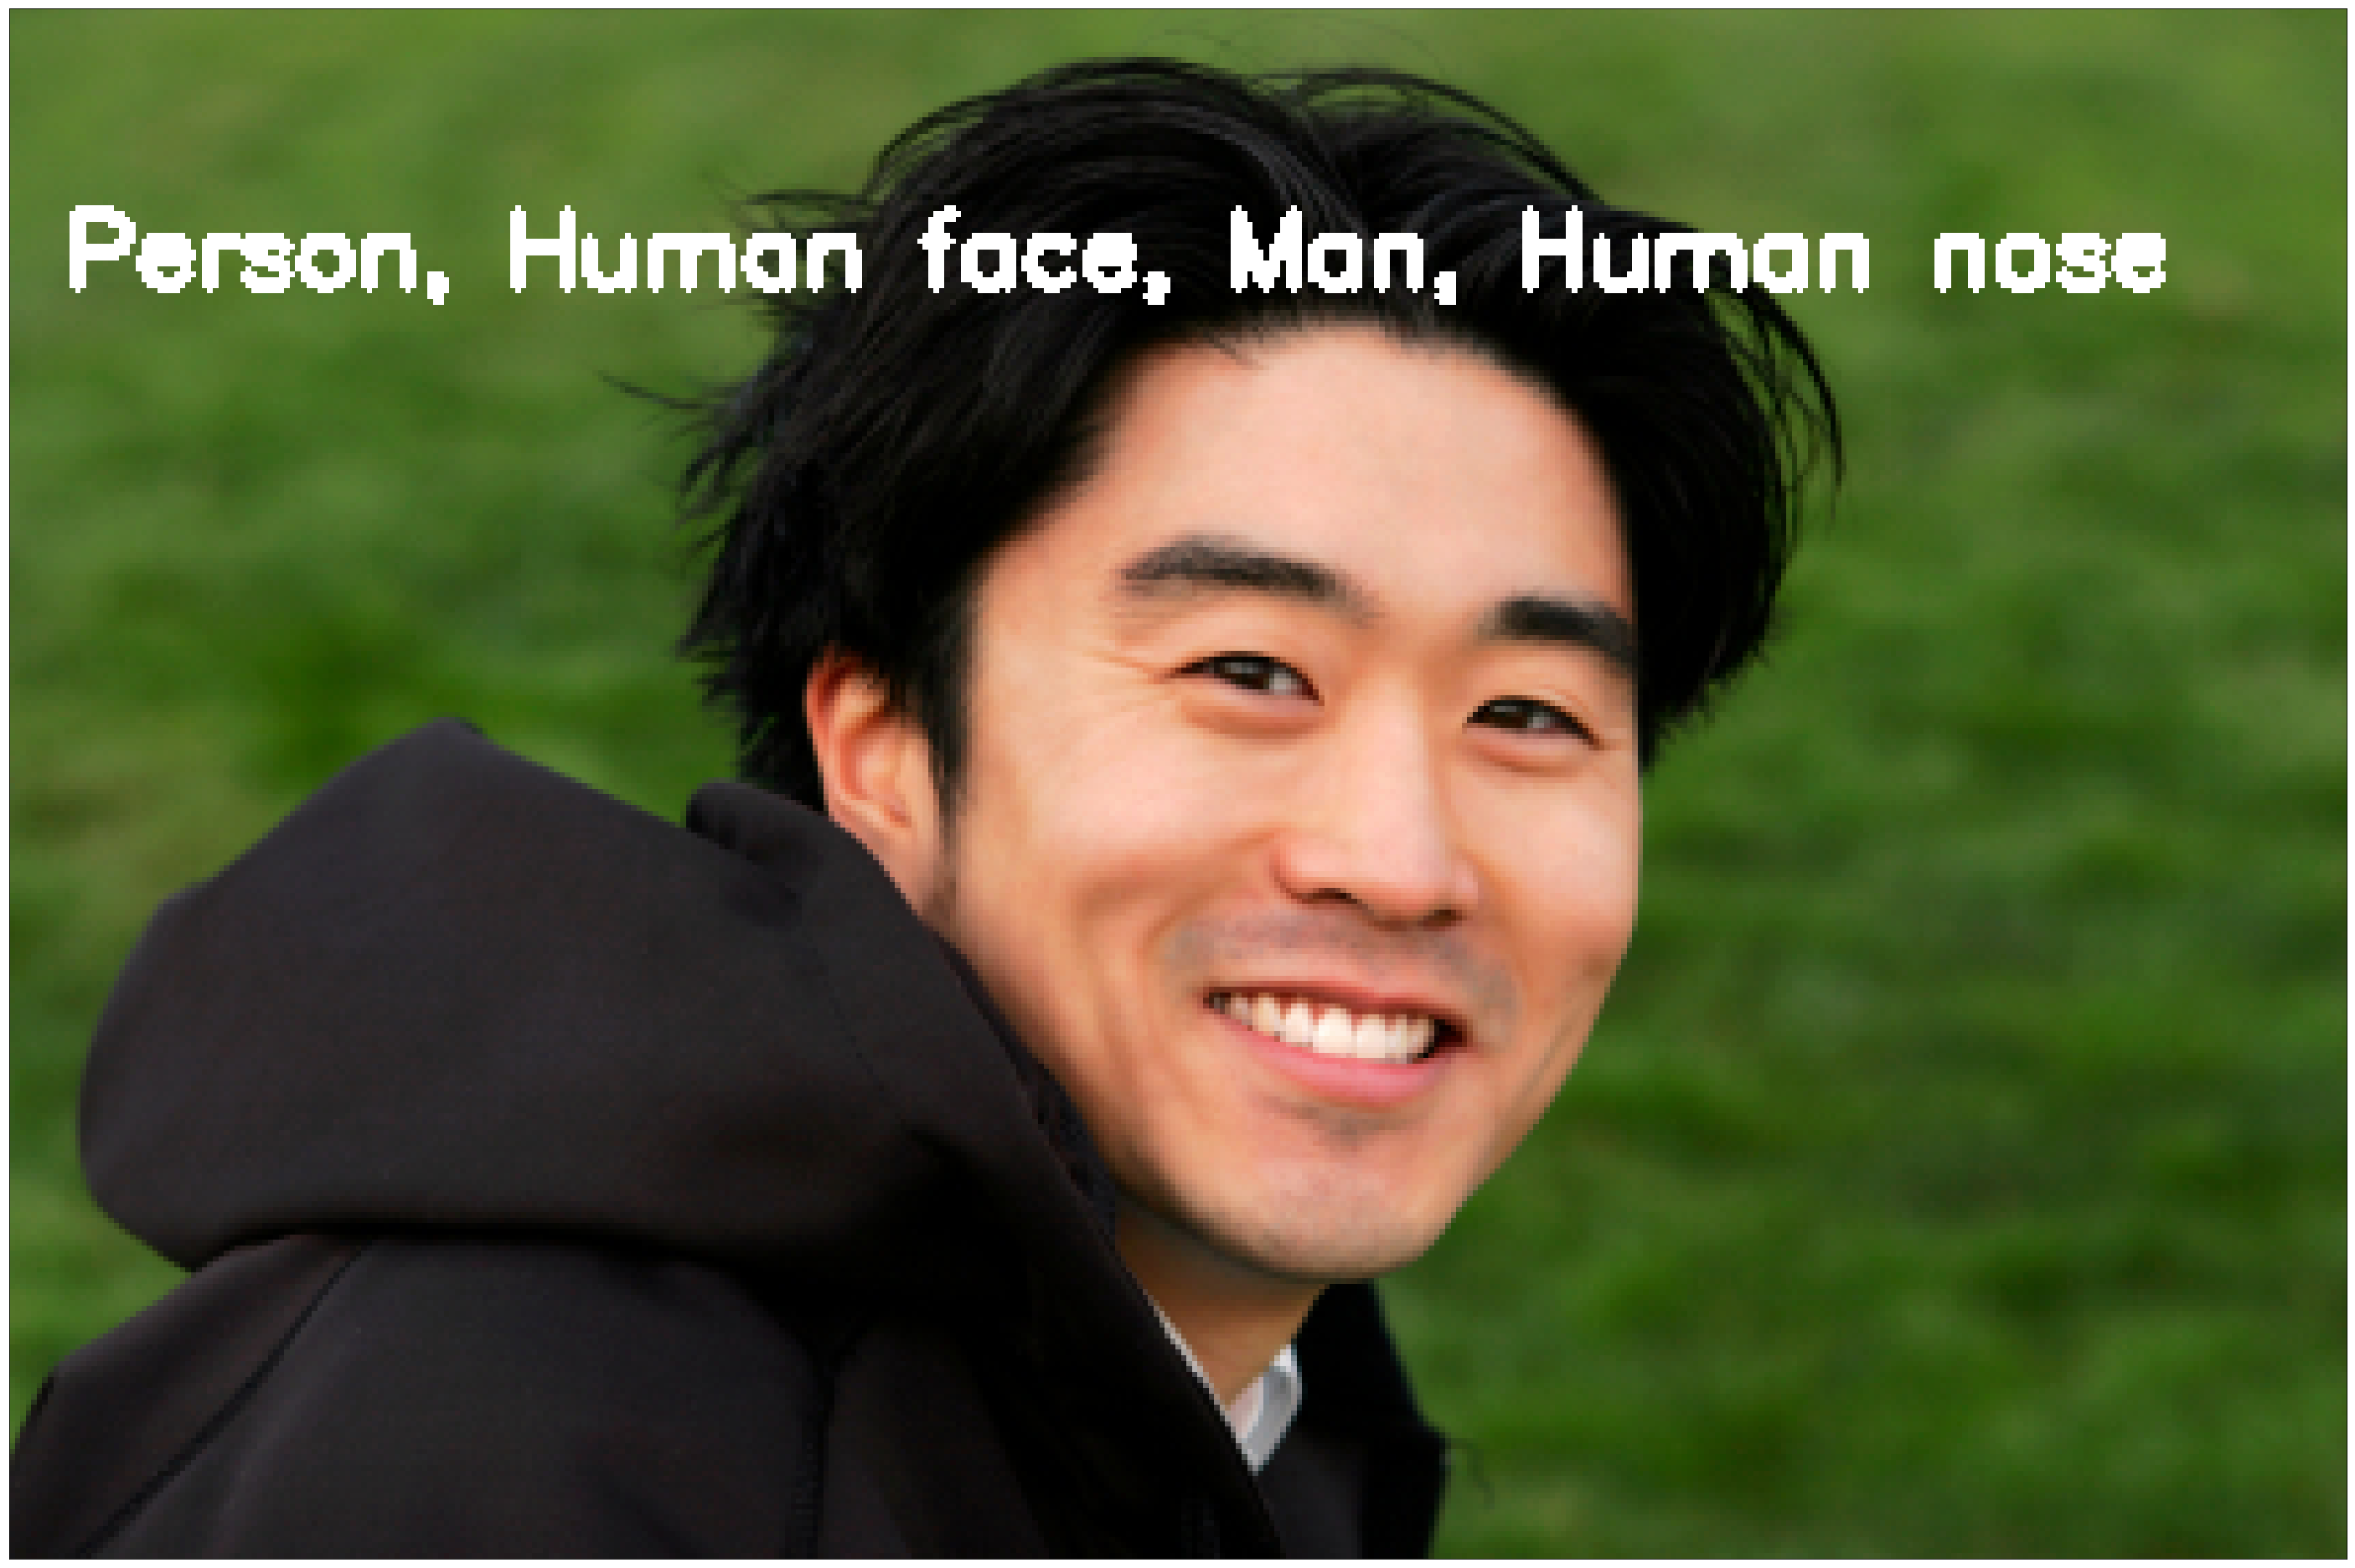

In [13]:
run_pred("../../rds_images/1.jpg")

['Person', 'Human face', 'Statue', 'Clothing', 'Man']
[[0.9965318  0.16549289 0.14858802 0.08848869 0.07238684]]


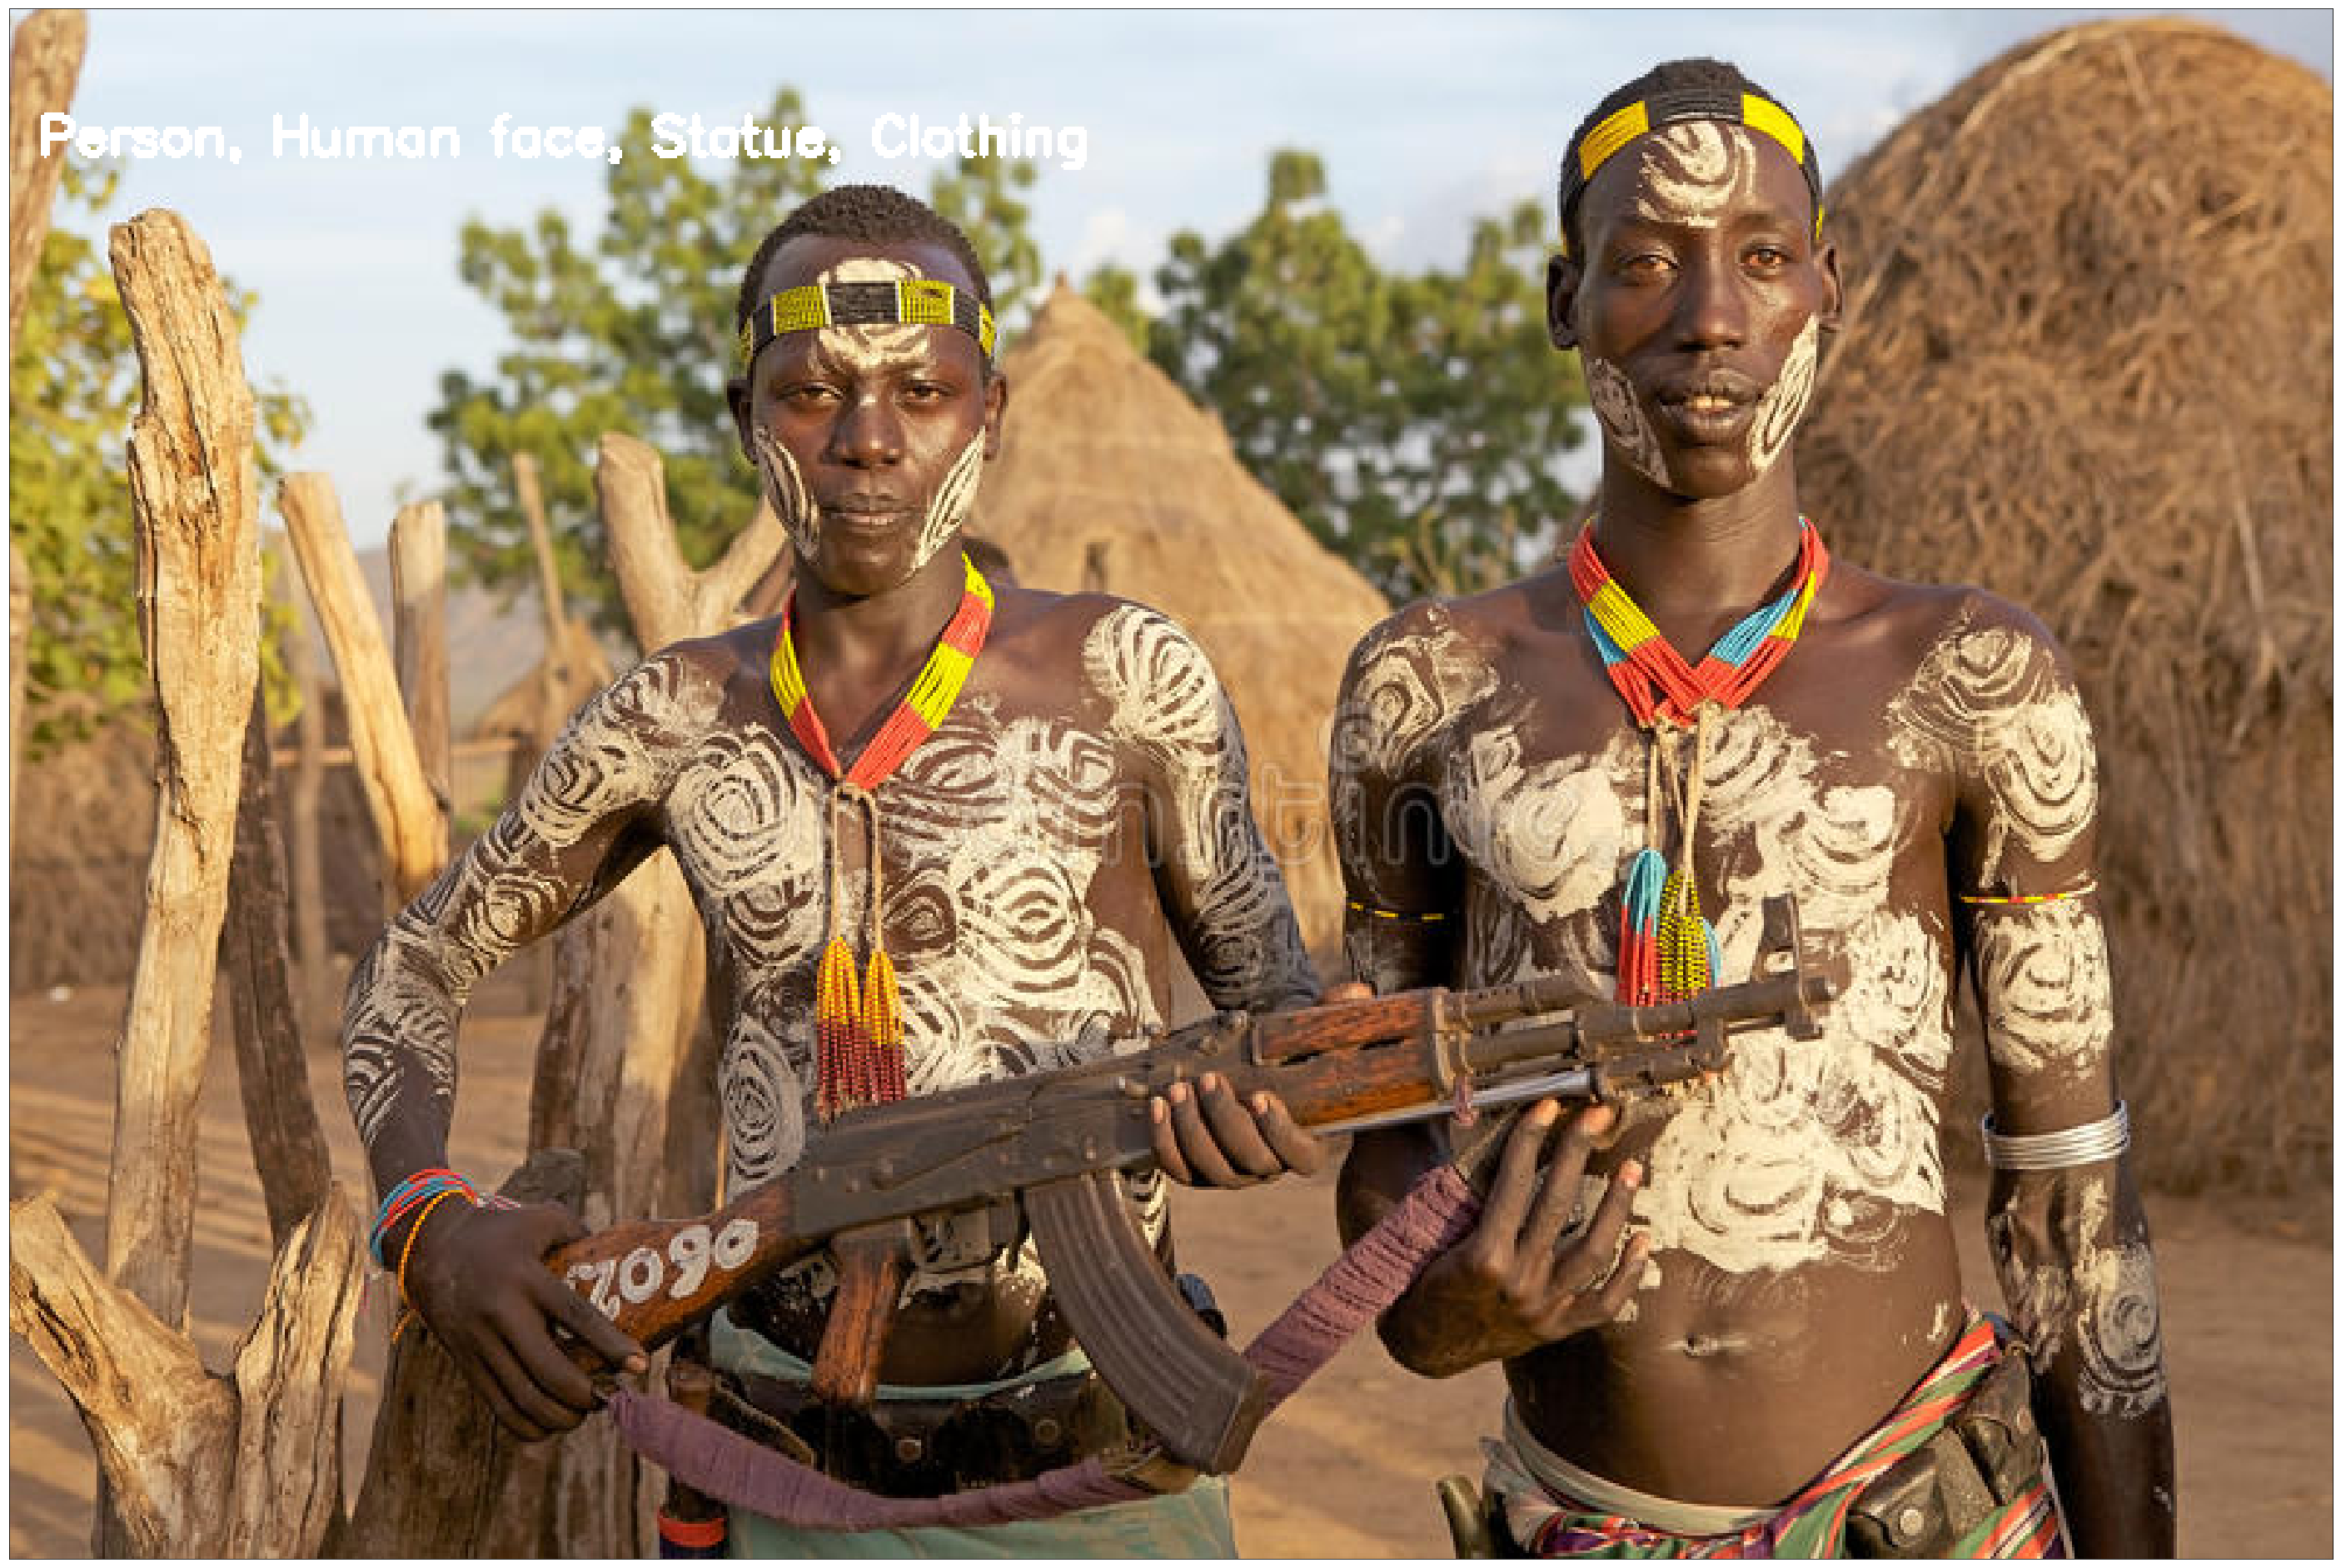

In [14]:
run_pred("../../rds_images/2.jpg")

['Person', 'Human face', 'Woman', 'Girl', 'Lipstick']
[[0.95777553 0.39539498 0.33136484 0.13188384 0.06129196]]


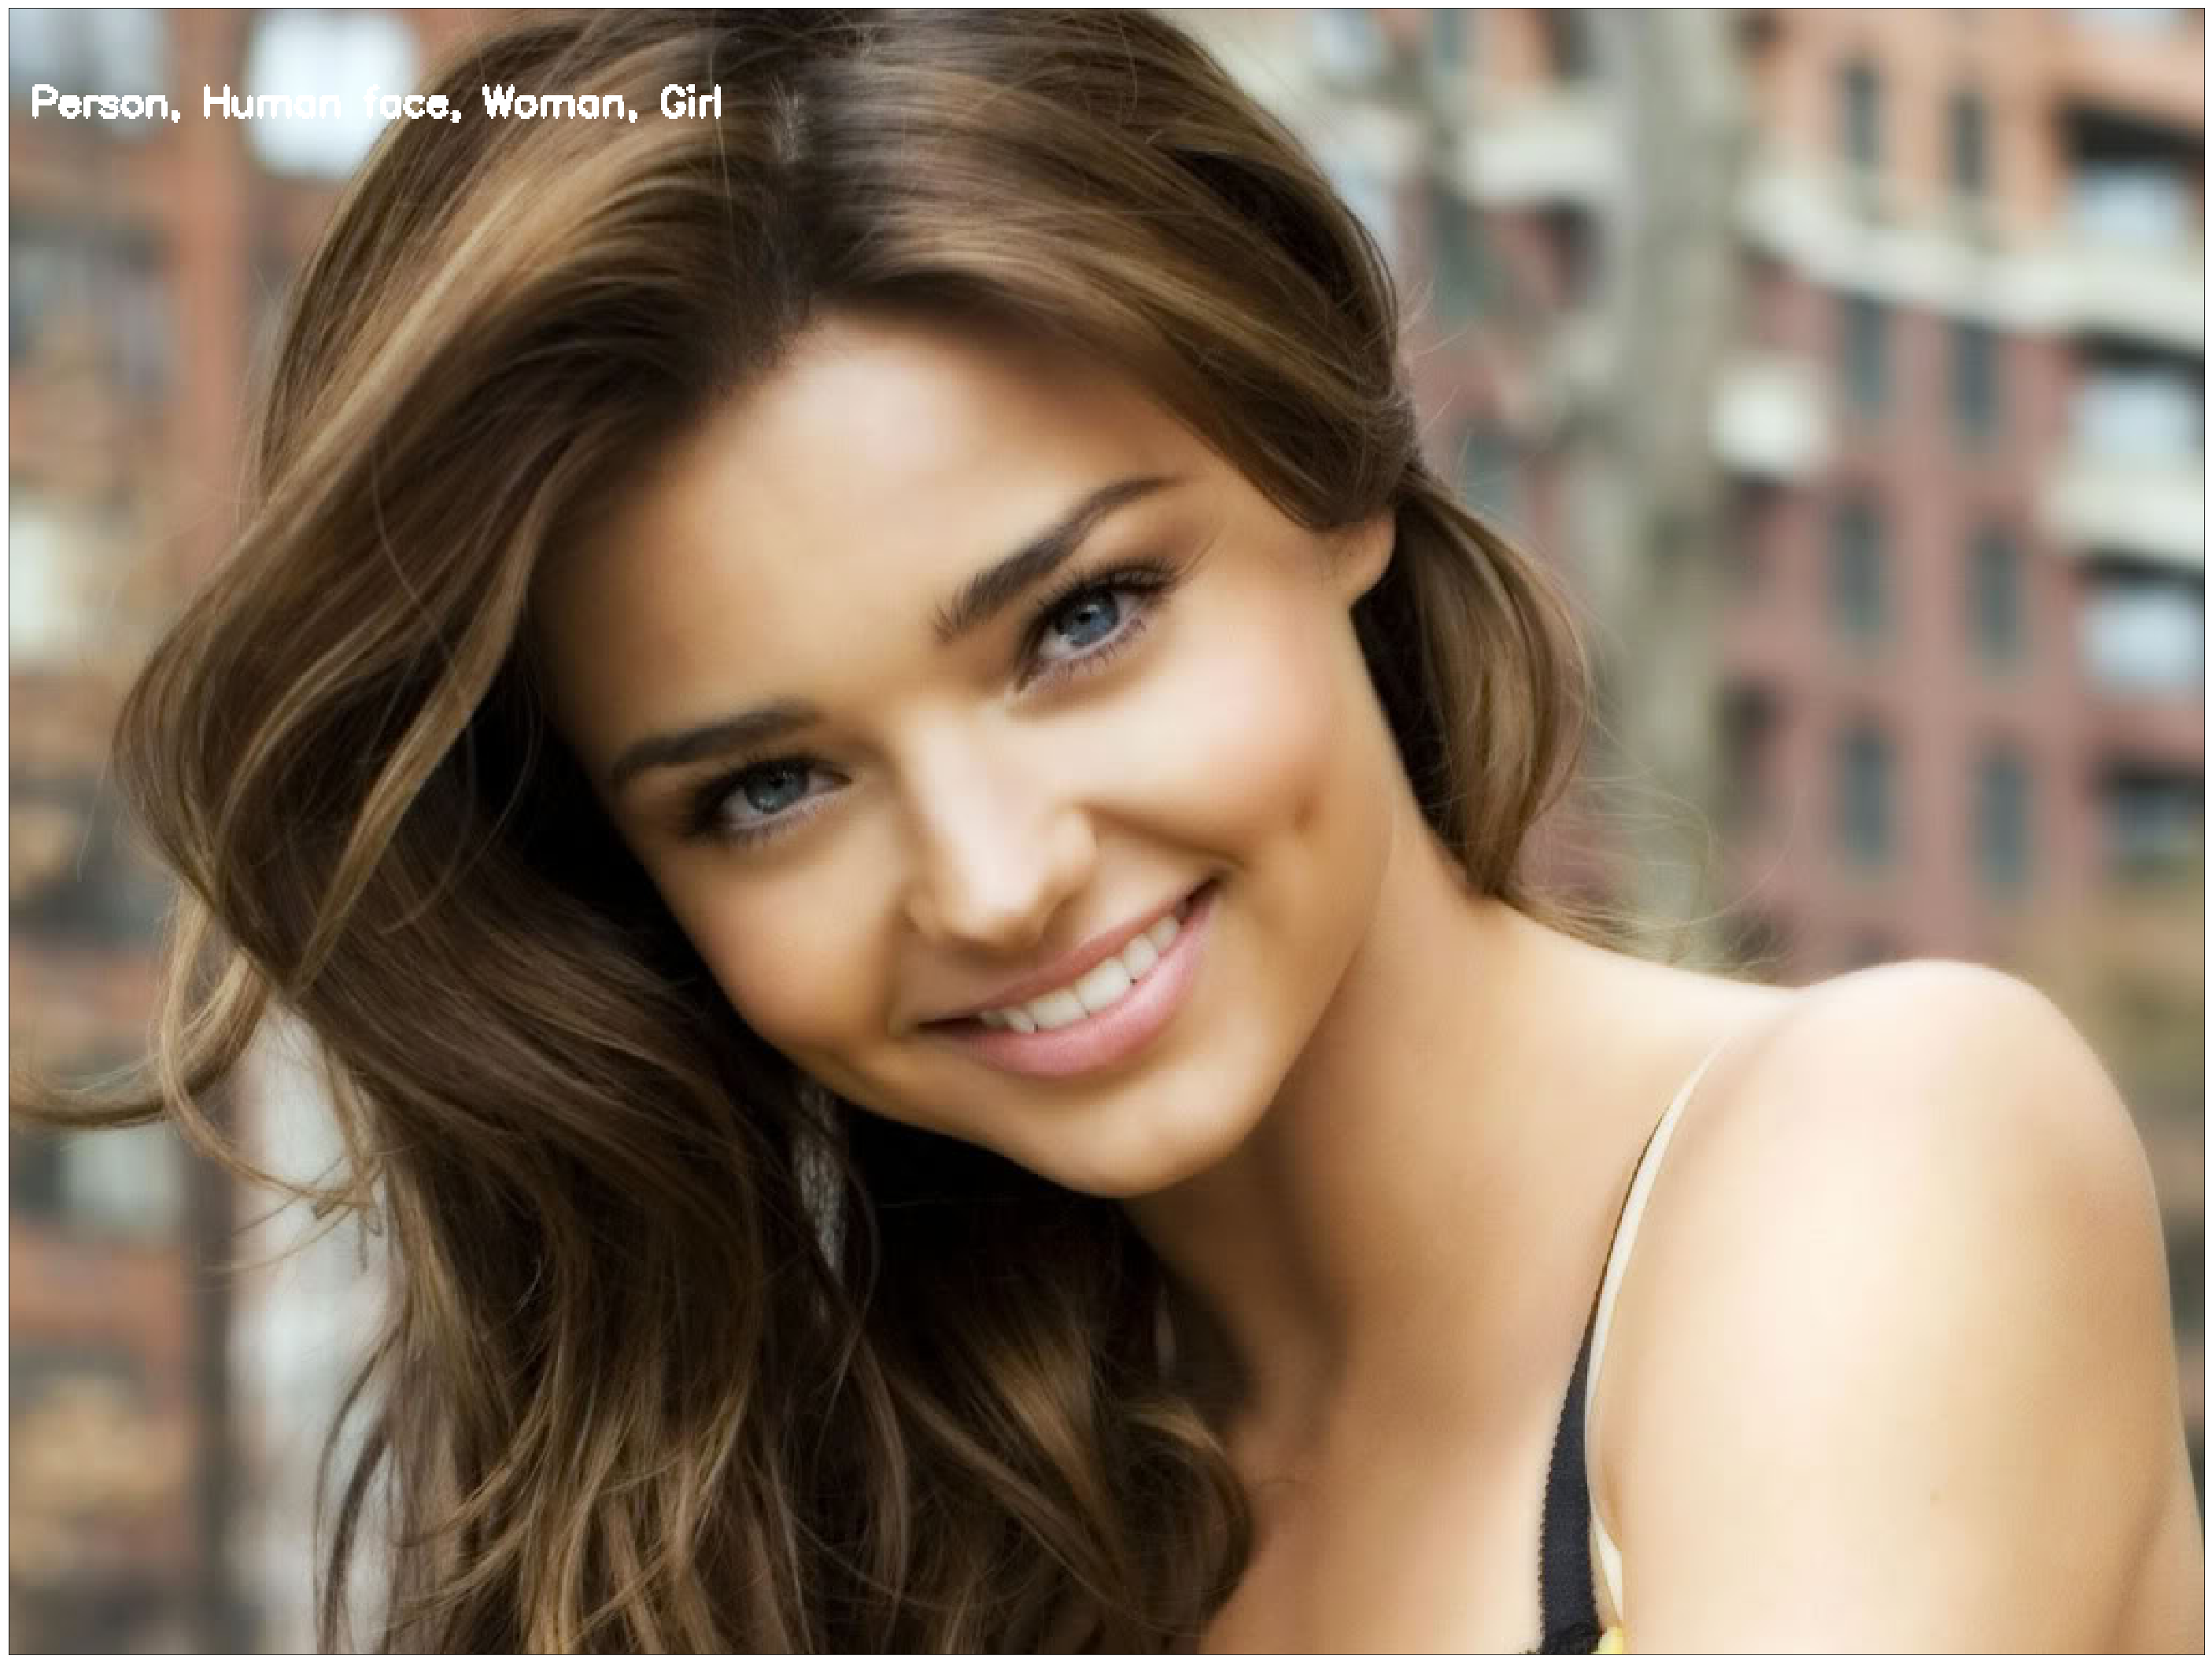

In [44]:
run_pred("../../rds_images/4.jpg")

# Baseline pretrained models

In [42]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True).to(device)

In [43]:
with open('../../imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

In [23]:
def baseline_pred(path):
    transform2 = T.Compose([           
     T.Resize(256),                   
     T.CenterCrop(224),               
     T.ToTensor(),                    
     T.Normalize(                     
     mean=[0.485, 0.456, 0.406],               
     std=[0.229, 0.224, 0.225]                 \
    )])
    img = Image.open(path)
    img_t = transform2(img)
    batch_t = torch.unsqueeze(img_t, 0)
    resnet50.eval()
    out = resnet50(batch_t.to(device))
    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    preds = [(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]
    print(preds)

In [24]:
baseline_pred("../../rds_images/1.jpg")

[('suit, suit of clothes', 20.470563888549805), ('mortarboard', 11.903887748718262), ("academic gown, academic robe, judge's robe", 6.5756449699401855), ('sweatshirt', 2.9812514781951904), ('groom, bridegroom', 2.759363889694214)]


In [25]:
baseline_pred("../../rds_images/2.jpg")

[('assault rifle, assault gun', 50.307621002197266), ('rifle', 10.713643074035645), ('military uniform', 10.432975769042969), ('comic book', 4.509642601013184), ('whistle', 3.397719144821167)]


In [26]:
baseline_pred("../../rds_images/3.jpg")

[('suit, suit of clothes', 12.834247589111328), ('lab coat, laboratory coat', 7.5804643630981445), ('Windsor tie', 5.796486854553223), ('hand-held computer, hand-held microcomputer', 3.6384477615356445), ('notebook, notebook computer', 2.581756353378296)]


In [28]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /home/rm5310/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [29]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Using cache found in /home/rm5310/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [31]:
ssd_model.to('cuda')
ssd_model.eval()
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [32]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [33]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [34]:
classes_to_labels = utils.get_coco_object_dictionary()

In [39]:
for i in range(len(best_results_per_input)):
    bbox, classes, confidence = best_results_per_input[i]
    print([classes_to_labels[idx - 1] for idx in classes])

['dining table', 'person']
['oven']
['chair', 'traffic light', 'person']
